In [2]:
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tqdm
from scipy import signal
from scipy.signal import find_peaks_cwt
from matplotlib import rcParams
from statsmodels.graphics.tsaplots import plot_acf

In [1]:
class Analysis():
    def __init__(self,filePath,grid_lenth):
        self.filePath=filePath
        self.lenth=0
        self.datas=[]
        self.data_columns=[]
        self.hatching_points=[]
        self.onset_points=[]
        self.max_min_diff=[]
        self.grid_lenth=grid_lenth
        self.filtered_signals=[]
        self.total_movements=[]
        self.average_above_threshold=[]
        self.durations=[]
        self.moving_percentage=[]
        self.average_bout=[]

    def All_computing(self):
        self.loading_datas()
        self.max_min_run()
        self.hatching_onset_detection()
        self.hatching_complete_detection()
        self.total_movement_quantity()
        self.average_movement_magnitude()
        self.calculate_durations()
        self.calculate_moving_percentage()
        self.calculate_average_bout()


    def loading_datas(self):
        print("Data loading...")
        for each_file in os.listdir(self.filePath):
            if each_file.endswith(".csv"):
                current=pd.read_csv(self.filePath + each_file)
                self.datas.append(current)
                self.data_columns.append(current.columns)
        self.lenth =len(self.datas)

    def knn_norm(self,data, k=7, mode="max"):
        lenth = len(data)
        output_list = []
        for i in range(lenth - k):
            if mode == "max":
                output_list.append((np.max(data[i:i + k])))
            elif mode == "mean":
                output_list.append((np.mean(data[i:i + k])))
            elif mode == "min":
                output_list.append((np.min(data[i:i + k])))
        return np.hstack((np.ones(lenth-len(output_list))*output_list[0],np.array(output_list)))

    def max_min_run(self):
        for each_ in range(self.lenth):
            diffs=[]
            for j in tqdm.tqdm(range(self.grid_lenth)):
                normBright = np.array(self.datas[each_][self.data_columns[each_][j]])
                normBright_max = self.knn_norm(normBright, 60, "max")
                normBright_min = self.knn_norm(normBright, 60, "min")
                diff = normBright_max - normBright_min
                diffs.append(copy.deepcopy(diff))
            self.max_min_diff.append(diffs)
        self.max_min_diff=np.array(self.max_min_diff)


    def hatching_onset_detection(self):
        print("calculate hatching onset point")
        for each_ in range(self.lenth):
            onset_point=[]
            filtered_signals=[]
            for j in tqdm.tqdm(range(self.grid_lenth)):
                diff=self.max_min_diff[each_][j]
                cut= diff[0:5000]
                threshold= np.max(cut)
                onset_point.append(np.where(diff>threshold)[0][0])
                diff[np.where(diff<=threshold)[0]]=0
                diff[np.where(diff>threshold)[0][0]]=0
                filtered_signals.append(diff)
            self.onset_points.append(onset_point)
            self.filtered_signals.append(filtered_signals)
        self.onset_points=np.array(self.onset_points)
        self.filtered_signals=np.array(self.filtered_signals)

    def hatching_complete_detection(self):
        print("calculate hatching complete")
        for each_ in range(self.lenth):
            hatching_=[]
            maxss=[]
            for j in tqdm.tqdm(range(self.grid_lenth)):
                ndiff=self.knn_norm(self.max_min_diff[each_][j],8000,"mean")
                increase_point=np.where(ndiff>np.mean(ndiff)*1.2)[0][0]
                cut=ndiff[:increase_point]
                maxs =find_peaks_cwt(cut[10000:],500)
                maxs+=10000
                cuted=maxs[-2]
                maxss.append((maxs[-2],maxs[-1]))
                cut=cut[maxs[-2]:maxs[-1]]
                mins =find_peaks_cwt(cut**-1,80)
                predict=0
                reverse_min = mins[::-1]
                for i in range(len(mins)):
                    if i ==0:
                        continue
                    else:
                        if cut[reverse_min[i]] > cut[reverse_min[i-1]]:
                            predict=reverse_min[i-1]+maxs[-2]
                            #hatching_points.append(predict)
                            break
                if predict<(maxs[-2]+maxs[-1])/2:
                    hatching_.append(int((maxs[-1]+(maxs[-2]+maxs[-1])/2)/2))
                else:
                    hatching_.append(predict)
            self.hatching_points.append(hatching_)
        self.hatching_points=np.array(self.hatching_points)

    def total_movement_quantity(self):
        print("total movement quantity...")
        self.total_movements=[]
        for each_ in range(self.lenth):
            Sum_above_threshold=[]
            for i in tqdm.tqdm(range(self.grid_lenth)):
                Sum_above_threshold.append(len(np.where(self.filtered_signals[each_][i][self.onset_points[each_][i]:self.hatching_points[each_][i]]!=0)[0]))
            self.total_movements.append(Sum_above_threshold)
        self.total_movements=np.array(self.total_movements)

    def average_movement_magnitude(self):
        print("average movement magnitude...")
        for each_ in range(self.lenth):
            Average_of_values=[]
            for i in tqdm.tqdm(range(self.grid_lenth)):
                Average_of_values.append(np.average(self.datas[each_][self.data_columns[each_][i]][np.where(self.filtered_signals[each_][i][self.onset_points[each_][i]:self.hatching_points[each_][i]]!=0)[0]]))
            self.average_above_threshold.append(Average_of_values)
        self.average_above_threshold=np.array(self.average_above_threshold)

    def calculate_durations(self):
        print("calculate durations...")
        for each_ in range(self.lenth):
            Duration=[]
            for i in tqdm.tqdm(range(self.grid_lenth)):
                Duration.append(len(self.filtered_signals[each_][i][self.onset_points[each_][i]:self.hatching_points[each_][i]]))
            self.durations.append(Duration)
        self.durations=np.array(self.durations)

    def calculate_moving_percentage(self):
        print("calculate moving percentage...")
        for each_ in range(self.lenth):
            Moving_Percentage=[]
            for i in tqdm.tqdm(range(self.grid_lenth)):
                Moving_Percentage.append(len(np.where(self.filtered_signals[each_][i][self.onset_points[each_][i]:self.hatching_points[each_][i]]!=0)[0])/len(self.filtered_signals[each_][i]))
            self.moving_percentage.append(Moving_Percentage)
        self.moving_percentage=np.array(self.moving_percentage)

    def calculate_average_bout(self):
        print("calculate average bout")
        for each_ in range(self.lenth):
            Average_bout=[]
            for i in tqdm.tqdm(range(self.grid_lenth)):
                pos = np.where(self.filtered_signals[each_][i] > 0)[0]
                split = np.where(np.diff(pos) != 1)[0] + 1
                arr=np.split(self.filtered_signals[each_][i][pos],split)
                lenths=[]
                for j in arr:
                    lenths.append(len(j))
                Average_bout.append(np.mean(lenths))
            self.average_bout.append(Average_bout)
        self.average_bout=np.array(self.average_bout)


    def Box_plot(self,data):
        plt.figure(figsize=(13,10), dpi= 80)
        sns.boxplot(y=data[0])
        plt.show()

    def specgram_plot(self,no):
        plt.figure(figsize=(8,23))
        for i in range(24):
            current=np.array_split(self.datas[no][self.data_columns[no][i]][self.onset_points[no][i]:self.hatching_points[no][i]],8)
            for j in range(8):
                plt.subplot(24,8,i*8+j+1)
                plt.specgram(current[j], Fs=10)
                plt.xticks([])
                plt.yticks([])
                if j==0:
                    plt.ylabel(str(i+1))




In [94]:
filePath = "../../data/"
#fileName = "output2022-04-27T15_16_04.csv"
fileName = "Raw1.csv"

In [95]:
test1=Analysis(filePath,24)
test1.All_computing()

Data loading...


100%|██████████| 24/24 [00:14<00:00,  1.63it/s]


calculate hatching onset point


100%|██████████| 24/24 [00:00<00:00, 2179.76it/s]


calculate hatching complete


100%|██████████| 24/24 [01:31<00:00,  3.81s/it]


total movement quantity...


100%|██████████| 24/24 [00:00<00:00, 11988.01it/s]


average movement magnitude...


100%|██████████| 24/24 [00:00<00:00, 1198.89it/s]


calculate durations...


100%|██████████| 24/24 [00:00<00:00, 23978.87it/s]


calculate moving percentage...


100%|██████████| 24/24 [00:00<00:00, 7994.23it/s]


calculate average bout


100%|██████████| 24/24 [00:00<00:00, 1498.63it/s]


In [96]:
test1.onset_points

array([[12638,  6325, 10480,  6251,  8481, 15360,  9285,  7129,  5026,
         5494,  7724,  5623,  5260,  5331, 11453, 14128,  6577,  6595,
         7962, 14035, 11625,  5685,  9352,  6959]], dtype=int64)

In [97]:
test1.hatching_points

array([[57101, 62597, 56775, 65733, 68540, 68414, 65772, 58291, 67882,
        70282, 48307, 45306, 69443, 64994, 71988, 57178, 69374, 22794,
        88111, 66001, 78177, 71372, 74792, 77239]], dtype=int64)

In [98]:
test1.onset_points

array([[12638,  6325, 10480,  6251,  8481, 15360,  9285,  7129,  5026,
         5494,  7724,  5623,  5260,  5331, 11453, 14128,  6577,  6595,
         7962, 14035, 11625,  5685,  9352,  6959]], dtype=int64)

In [99]:
test1.max_min_diff

array([[[0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        ...,
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 2.082, 2.082, 2.082],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]]])

In [100]:
test1.filtered_signals

array([[[0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        ...,
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 2.082, 2.082, 2.082],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]]])

In [101]:
test1.total_movements

array([[19916, 17997, 21317, 31947, 21881, 21862, 34281, 21999, 25576,
        30043, 10427, 13359, 21879, 28690, 27945, 17129, 24735,  4949,
        30282, 20395, 26744, 18149, 21712, 34310]])

In [102]:
test1.average_above_threshold

array([[50.94847776, 62.10278385, 43.45154351, 53.83759921, 56.01970472,
        39.3326654 , 53.04189026, 51.89456439, 50.24489568, 47.01997643,
        47.28268649, 45.81606146, 47.46884442, 52.11769348, 44.12371354,
        57.72309271, 63.8730264 , 47.21149242, 52.57516653, 46.2994884 ,
        45.70614927, 53.99286622, 58.03675695, 55.91314471]])

In [103]:
test1.durations

array([[44463, 56272, 46295, 59482, 60059, 53054, 56487, 51162, 62856,
        64788, 40583, 39683, 64183, 59663, 60535, 43050, 62797, 16199,
        80149, 51966, 66552, 65687, 65440, 70280]])

In [104]:
test1.moving_percentage

array([[0.19954512, 0.18031801, 0.21358221, 0.32008777, 0.21923312,
        0.21904275, 0.3434729 , 0.2204154 , 0.25625457, 0.30101095,
        0.10447163, 0.13384833, 0.21921308, 0.28745479, 0.27999038,
        0.17162123, 0.24782831, 0.0495857 , 0.30340557, 0.20434438,
        0.26795716, 0.18184095, 0.21753985, 0.34376346]])

In [105]:
test1.average_bout

array([[150.93607306, 168.63043478, 118.71875   , 142.32802548,
        226.43913043, 143.34076433, 144.68322981, 140.17886179,
        161.40802676, 138.30699088, 182.29268293, 145.52083333,
        112.37971698, 131.46496815, 130.36387435, 174.76536313,
        139.43213296, 112.87698413,  98.1264637 , 138.61048689,
        139.02723735, 128.49206349,  94.42897727, 130.63265306]])

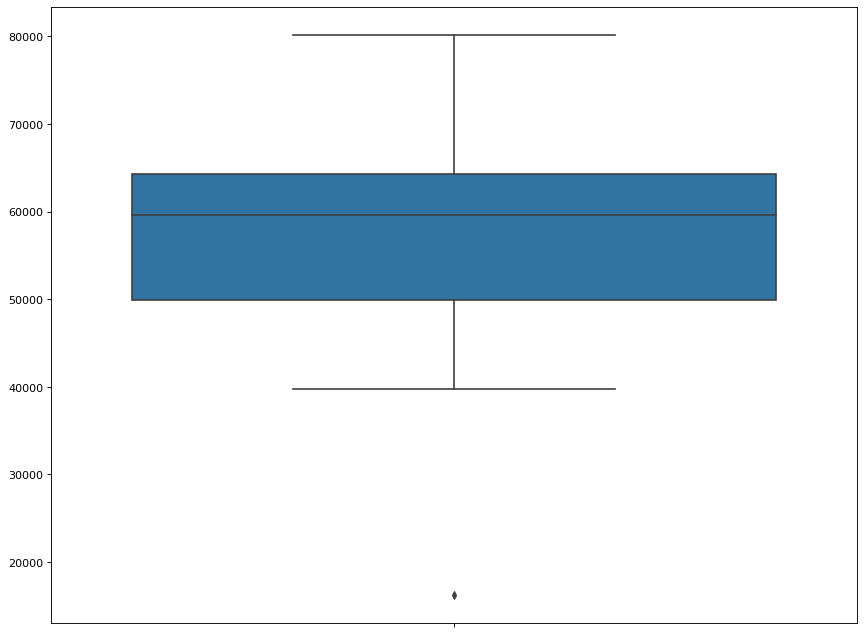

In [106]:
test1.Box_plot(test1.durations)

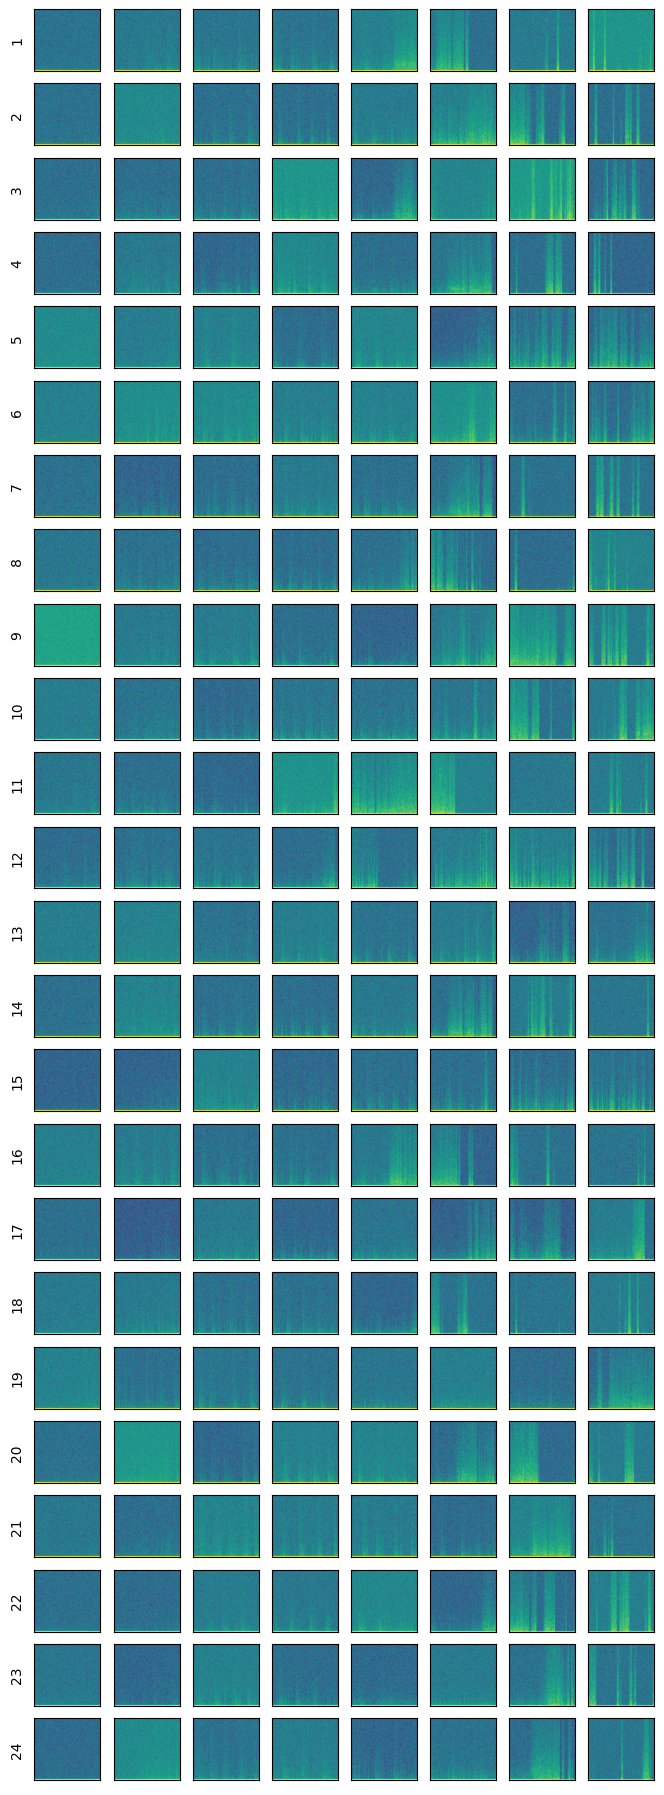

In [107]:
test1.specgram_plot(0)

0